# Evaluation Results Analysis

This notebook analyzes shopping agent evaluation results from a multirun directory.

## Parameters
Set the `EVAL_DIR` parameter below to point to your evaluation run directory.

In [ ]:
# Parameters - modify this path to analyze different eval runs
EVAL_DIR = "../multirun/2026-02-05/23-12-11"

In [3]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
from adjustText import adjust_text

# Configure matplotlib for inline display
plt.style.use("seaborn-v0_8-whitegrid")
%matplotlib inline

<cell_type>markdown</cell_type>## Fetch Model Pricing

Fetches pricing data from LiteLLM (for Groq and other models) and OpenRouter API.

In [4]:
def fetch_litellm_pricing() -> dict:
    """Fetch model pricing from LiteLLM's GitHub repository.

    This is the same source browser-use uses for cost calculation.

    Returns:
        dict: Mapping of model_id -> {prompt_price, completion_price} in USD per token
    """
    try:
        url = "https://raw.githubusercontent.com/BerriAI/litellm/main/model_prices_and_context_window.json"
        req = urllib.request.Request(url, headers={"User-Agent": "eval-analysis/1.0"})
        with urllib.request.urlopen(req, timeout=30) as response:
            data = json.loads(response.read().decode())

        pricing = {}
        for model_id, model_data in data.items():
            if not isinstance(model_data, dict):
                continue

            input_cost = model_data.get("input_cost_per_token", 0) or 0
            output_cost = model_data.get("output_cost_per_token", 0) or 0

            pricing[model_id] = {
                "prompt_price": input_cost,
                "completion_price": output_cost,
                "name": model_id,
                "max_tokens": model_data.get("max_tokens"),
            }

        print(f"Fetched pricing for {len(pricing)} models from LiteLLM")
        return pricing
    except Exception as e:
        print(f"Warning: Could not fetch LiteLLM pricing: {e}")
        return {}


def fetch_openrouter_pricing() -> dict:
    """Fetch model pricing from OpenRouter API.

    Returns:
        dict: Mapping of model_id -> {prompt_price, completion_price} in USD per token
    """
    try:
        url = "https://openrouter.ai/api/v1/models"
        req = urllib.request.Request(url, headers={"User-Agent": "eval-analysis/1.0"})
        with urllib.request.urlopen(req, timeout=30) as response:
            data = json.loads(response.read().decode())

        pricing = {}
        for model in data.get("data", []):
            model_id = model.get("id", "")
            model_pricing = model.get("pricing", {})

            # Parse pricing (values are strings in USD per token)
            prompt_price = float(model_pricing.get("prompt", "0") or "0")
            completion_price = float(model_pricing.get("completion", "0") or "0")

            pricing[model_id] = {
                "prompt_price": prompt_price,
                "completion_price": completion_price,
                "name": model.get("name", model_id),
                "context_length": model.get("context_length"),
            }

            # Also store by short name for easier matching
            short_name = model_id.split("/")[-1] if "/" in model_id else model_id
            if short_name not in pricing:
                pricing[short_name] = pricing[model_id]

        print(f"Fetched pricing for {len(data.get('data', []))} models from OpenRouter")
        return pricing
    except Exception as e:
        print(f"Warning: Could not fetch OpenRouter pricing: {e}")
        return {}


# Fetch pricing data from both sources
litellm_pricing = fetch_litellm_pricing()
openrouter_pricing = fetch_openrouter_pricing()

Fetched pricing for 2477 models from LiteLLM
Fetched pricing for 346 models from OpenRouter


## Load Evaluation Data

In [5]:
def find_model_pricing(model_id: str, provider: str, litellm_data: dict, openrouter_data: dict) -> tuple:
    """Find pricing for a model, using the appropriate source based on provider.

    For Groq models, uses LiteLLM pricing with groq/ prefix.
    For OpenRouter models, uses OpenRouter API pricing.
    For OpenAI models, uses LiteLLM pricing.

    Returns:
        tuple: (prompt_price, completion_price, source) or (None, None, None) if not found
    """
    # For Groq provider, use LiteLLM pricing with groq/ prefix
    if provider == "groq":
        # Try with groq/ prefix (e.g., "groq/openai/gpt-oss-120b" or "groq/llama-3.3-70b-versatile")
        groq_model = f"groq/{model_id}"
        if groq_model in litellm_data:
            p = litellm_data[groq_model]
            return p["prompt_price"], p["completion_price"], "litellm"

        # Some models might need different prefix patterns
        # Try without the openai/ prefix for models like "openai/gpt-oss-120b"
        if "/" in model_id:
            alt_groq_model = f"groq/{model_id.split('/')[-1]}"
            if alt_groq_model in litellm_data:
                p = litellm_data[alt_groq_model]
                return p["prompt_price"], p["completion_price"], "litellm"

        return None, None, None

    # For OpenAI provider, try LiteLLM first
    if provider == "openai":
        if model_id in litellm_data:
            p = litellm_data[model_id]
            return p["prompt_price"], p["completion_price"], "litellm"

    # For OpenRouter or fallback, use OpenRouter pricing
    # Try exact match first
    if model_id in openrouter_data:
        p = openrouter_data[model_id]
        return p["prompt_price"], p["completion_price"], "openrouter_api"

    # Try without provider prefix
    short_name = model_id.split("/")[-1] if "/" in model_id else model_id
    if short_name in openrouter_data:
        p = openrouter_data[short_name]
        return p["prompt_price"], p["completion_price"], "openrouter_api"

    # Try fuzzy matching - find models containing the short name
    for key in openrouter_data:
        if short_name.lower() in key.lower() or key.lower() in short_name.lower():
            p = openrouter_data[key]
            return p["prompt_price"], p["completion_price"], "openrouter_api"

    return None, None, None


def load_eval_results(eval_dir: str, litellm_data: dict = None, openrouter_data: dict = None) -> pd.DataFrame:
    """Load all eval_result.json files from the given directory."""
    eval_path = Path(eval_dir)
    results = []
    litellm_data = litellm_data or {}
    openrouter_data = openrouter_data or {}

    for json_file in eval_path.glob("*/eval_result.json"):
        with open(json_file) as f:
            data = json.load(f)

        # Extract key metrics
        config = data.get("config_summary", {})
        metrics = data.get("metrics", {})
        cost_metrics = data.get("cost_metrics", {})

        # Build model identifier
        model = config.get("llm_model", "unknown")
        provider = config.get("llm_provider", "unknown")

        # Clean up model name for display
        display_name = model.split("/")[-1] if "/" in model else model

        # Get token counts
        input_tokens = cost_metrics.get("token_usage", {}).get("input_tokens", 0)
        output_tokens = cost_metrics.get("token_usage", {}).get("output_tokens", 0)

        # Get existing cost from recorded data (if > 0)
        recorded_cost = cost_metrics.get("token_usage", {}).get("total_cost")
        if recorded_cost and recorded_cost > 0:
            estimated_cost = recorded_cost
            cost_source = "recorded"
        else:
            estimated_cost = cost_metrics.get("estimated_cost_usd")
            cost_source = "recorded" if estimated_cost is not None and estimated_cost > 0 else None

        # If no cost but we have tokens and pricing data, calculate cost
        if (estimated_cost is None or estimated_cost == 0) and input_tokens > 0:
            prompt_price, completion_price, source = find_model_pricing(model, provider, litellm_data, openrouter_data)
            if prompt_price is not None and completion_price is not None:
                estimated_cost = (input_tokens * prompt_price) + (output_tokens * completion_price)
                cost_source = source

        results.append(
            {
                "model": model,
                "model_display": display_name,
                "provider": provider,
                "success_rate": data.get("success_rate", 0),
                "success_pct": data.get("success_rate", 0) * 100,
                "status": data.get("status", "unknown"),
                "total_duration_seconds": metrics.get("total_duration_seconds"),
                "total_duration_minutes": metrics.get("total_duration_seconds", 0) / 60
                if metrics.get("total_duration_seconds")
                else None,
                "estimated_cost_usd": estimated_cost,
                "cost_source": cost_source,
                "input_tokens": input_tokens,
                "output_tokens": output_tokens,
                "items_requested": len(data.get("items_requested", [])),
                "items_successful": sum(1 for r in data.get("item_results", []) if r.get("status") == "success"),
                "run_dir": json_file.parent.name,
            }
        )

    df = pd.DataFrame(results)
    return df.sort_values("success_rate", ascending=False).reset_index(drop=True)


# Load data with pricing from both sources
df = load_eval_results(EVAL_DIR, litellm_pricing, openrouter_pricing)

print(f"Loaded {len(df)} evaluation results from {EVAL_DIR}")
print(f"Models tested: {df['model_display'].nunique()}")

# Report cost coverage
n_with_cost = df["estimated_cost_usd"].notna().sum()
n_from_litellm = (df["cost_source"] == "litellm").sum()
n_from_openrouter = (df["cost_source"] == "openrouter_api").sum()
n_recorded = (df["cost_source"] == "recorded").sum()
print(
    f"Cost data available for {n_with_cost}/{len(df)} runs ({n_recorded} recorded, {n_from_litellm} from LiteLLM, {n_from_openrouter} from OpenRouter)"
)

Loaded 26 evaluation results from ../multirun/2026-02-03/21-46-52
Models tested: 24
Cost data available for 20/26 runs (8 recorded, 1 from LiteLLM, 11 from OpenRouter)


## Summary Statistics

In [6]:
# Display summary table sorted by success rate
summary_cols = [
    "model_display",
    "provider",
    "success_pct",
    "total_duration_minutes",
    "estimated_cost_usd",
    "cost_source",
    "status",
]
summary = df[summary_cols].copy()
summary.columns = ["Model", "Provider", "Success %", "Duration (min)", "Cost (USD)", "Cost Source", "Status"]
summary["Success %"] = summary["Success %"].map("{:.0f}%".format)
summary["Duration (min)"] = summary["Duration (min)"].map(lambda x: f"{x:.1f}" if pd.notna(x) else "N/A")
summary["Cost (USD)"] = summary["Cost (USD)"].map(lambda x: f"${x:.4f}" if pd.notna(x) else "N/A")
summary["Cost Source"] = summary["Cost Source"].fillna("N/A")
display(summary)

,Model,Provider,Success %,Duration (min),Cost (USD),Cost Source,Status
0,gpt-4.1,openai,50%,10.0,$1.0007,recorded,partial
1,gpt-oss-20b,openrouter,50%,19.3,$0.0192,openrouter_api,partial
2,llama-3.3-nemotron-super-49b-v1.5,openrouter,50%,29.1,$0.0742,openrouter_api,partial
3,glm-4.7-flash,openrouter,50%,41.4,$0.0717,openrouter_api,partial
4,llama-4-maverick,openrouter,50%,25.9,$0.1717,openrouter_api,partial
5,deepseek-chat-v3-0324,openrouter,50%,14.7,$0.1082,openrouter_api,partial
6,minimax-m2,openrouter,50%,9.0,$0.2422,openrouter_api,partial
7,gpt-5-nano,openai,50%,13.7,$0.0621,recorded,partial
8,gpt-4.1-nano,openai,40%,11.0,$0.1267,recorded,partial
9,gpt-4.1-mini,openai,40%,9.6,$0.2853,recorded,partial


## Plot 1: Success Rate vs Cost

Shows the trade-off between model accuracy and API cost.

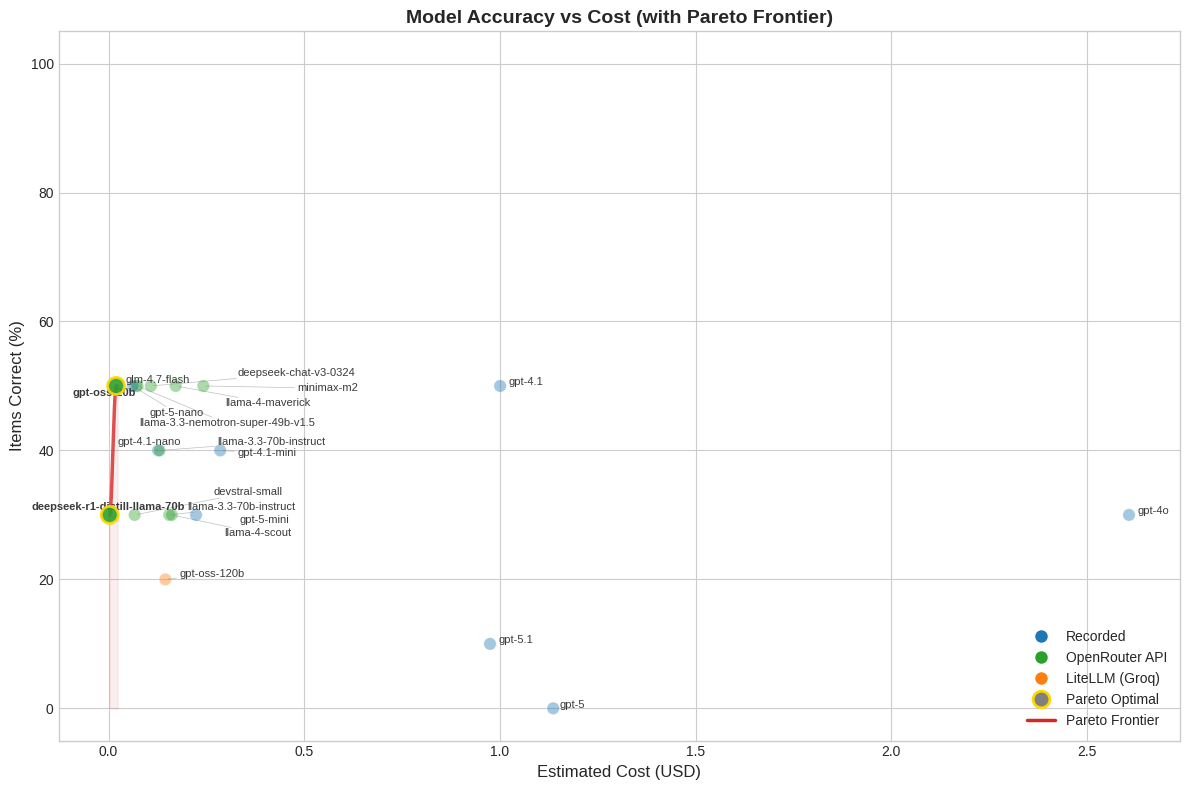


Showing 20 models with cost data
Pareto optimal models (2): deepseek-r1-distill-llama-70b, gpt-oss-20b


In [7]:
from scipy.interpolate import PchipInterpolator
from scipy.optimize import curve_fit


def compute_pareto_frontier(df, cost_col, success_col):
    """Compute Pareto optimal points (minimize cost, maximize success).

    Returns DataFrame of Pareto optimal points sorted by cost.
    """
    pareto_points = []

    # Sort by cost ascending
    df_sorted = df.sort_values(cost_col).reset_index(drop=True)

    max_success_seen = -1
    for idx, row in df_sorted.iterrows():
        # A point is Pareto optimal if its success is higher than any cheaper model
        if row[success_col] > max_success_seen:
            pareto_points.append(row)
            max_success_seen = row[success_col]

    return pd.DataFrame(pareto_points)


# Color mapping for cost sources
COST_SOURCE_COLORS = {
    "recorded": "#1f77b4",  # Blue for recorded costs
    "openrouter_api": "#2ca02c",  # Green for OpenRouter API
    "litellm": "#ff7f0e",  # Orange for LiteLLM (Groq models)
}

# Filter to models with cost data
df_with_cost = df[df["estimated_cost_usd"].notna()].copy()

if len(df_with_cost) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Compute Pareto frontier
    pareto_df = compute_pareto_frontier(df_with_cost, "estimated_cost_usd", "success_pct")
    pareto_models = set(pareto_df["model_display"])

    # Plot non-Pareto points first (smaller, more transparent)
    non_pareto = df_with_cost[~df_with_cost["model_display"].isin(pareto_models)]
    ax.scatter(
        non_pareto["estimated_cost_usd"],
        non_pareto["success_pct"],
        s=80,
        alpha=0.4,
        c=non_pareto["cost_source"].map(COST_SOURCE_COLORS).fillna("gray"),
        edgecolors="white",
        linewidths=0.5,
    )

    # Plot Pareto optimal points (larger, more prominent)
    pareto_in_df = df_with_cost[df_with_cost["model_display"].isin(pareto_models)]
    ax.scatter(
        pareto_in_df["estimated_cost_usd"],
        pareto_in_df["success_pct"],
        s=150,
        alpha=0.9,
        c=pareto_in_df["cost_source"].map(COST_SOURCE_COLORS).fillna("gray"),
        edgecolors="gold",
        linewidths=2,
        zorder=5,
    )

    # Create smooth Pareto frontier curve
    pareto_sorted = pareto_df.sort_values("estimated_cost_usd")
    x_pareto = pareto_sorted["estimated_cost_usd"].values
    y_pareto = pareto_sorted["success_pct"].values

    if len(x_pareto) >= 2:
        # Use PCHIP interpolation for smooth monotonic curve through Pareto points
        # Add boundary points for better curve behavior
        x_extended = np.concatenate([[x_pareto[0] * 0.5], x_pareto, [x_pareto[-1] * 2]])
        y_extended = np.concatenate([[y_pareto[0]], y_pareto, [y_pareto[-1]]])

        try:
            pchip = PchipInterpolator(x_extended, y_extended)
            x_smooth = np.linspace(x_pareto[0] * 0.8, x_pareto[-1] * 1.2, 200)
            y_smooth = pchip(x_smooth)

            # Clip to valid range
            y_smooth = np.clip(y_smooth, 0, 100)

            ax.plot(
                x_smooth,
                y_smooth,
                color="#d62728",
                linestyle="-",
                linewidth=2.5,
                alpha=0.8,
                label="Pareto Frontier",
                zorder=4,
            )
            ax.fill_between(x_smooth, y_smooth, alpha=0.08, color="#d62728")
        except Exception:
            # Fallback to simple line if interpolation fails
            ax.plot(
                x_pareto,
                y_pareto,
                color="#d62728",
                linestyle="-",
                linewidth=2.5,
                alpha=0.8,
                label="Pareto Frontier",
                zorder=4,
            )

    # Create text labels for adjustText
    texts = []
    for idx, row in df_with_cost.iterrows():
        fontweight = "bold" if row["model_display"] in pareto_models else "normal"
        texts.append(
            ax.text(
                row["estimated_cost_usd"],
                row["success_pct"],
                row["model_display"],
                fontsize=8,
                alpha=0.9,
                fontweight=fontweight,
            )
        )

    # Adjust text positions to avoid overlap
    adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle="-", color="gray", alpha=0.5, lw=0.5),
        expand=(1.2, 1.8),
        force_text=(0.9, 1.8),
        force_static=(0.1, 0.2),
        iter_lim=500,
    )

    # Add legend
    from matplotlib.lines import Line2D

    legend_elements = [
        Line2D([0], [0], marker="o", color="w", markerfacecolor="#1f77b4", markersize=10, label="Recorded"),
        Line2D([0], [0], marker="o", color="w", markerfacecolor="#2ca02c", markersize=10, label="OpenRouter API"),
        Line2D([0], [0], marker="o", color="w", markerfacecolor="#ff7f0e", markersize=10, label="LiteLLM (Groq)"),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="gray",
            markersize=12,
            markeredgecolor="gold",
            markeredgewidth=2,
            label="Pareto Optimal",
        ),
        Line2D([0], [0], color="#d62728", linewidth=2.5, label="Pareto Frontier"),
    ]
    ax.legend(handles=legend_elements, loc="lower right")

    ax.set_xlabel("Estimated Cost (USD)", fontsize=12)
    ax.set_ylabel("Items Correct (%)", fontsize=12)
    ax.set_title("Model Accuracy vs Cost (with Pareto Frontier)", fontsize=14, fontweight="bold")
    ax.set_ylim(-5, 105)

    plt.tight_layout()
    plt.show()

    print(f"\nShowing {len(df_with_cost)} models with cost data")
    print(f"Pareto optimal models ({len(pareto_df)}): {', '.join(pareto_df['model_display'].tolist())}")
else:
    print("No models have cost data available.")

## Plot 2: Time vs Success Rate

Shows the relationship between execution time and accuracy.

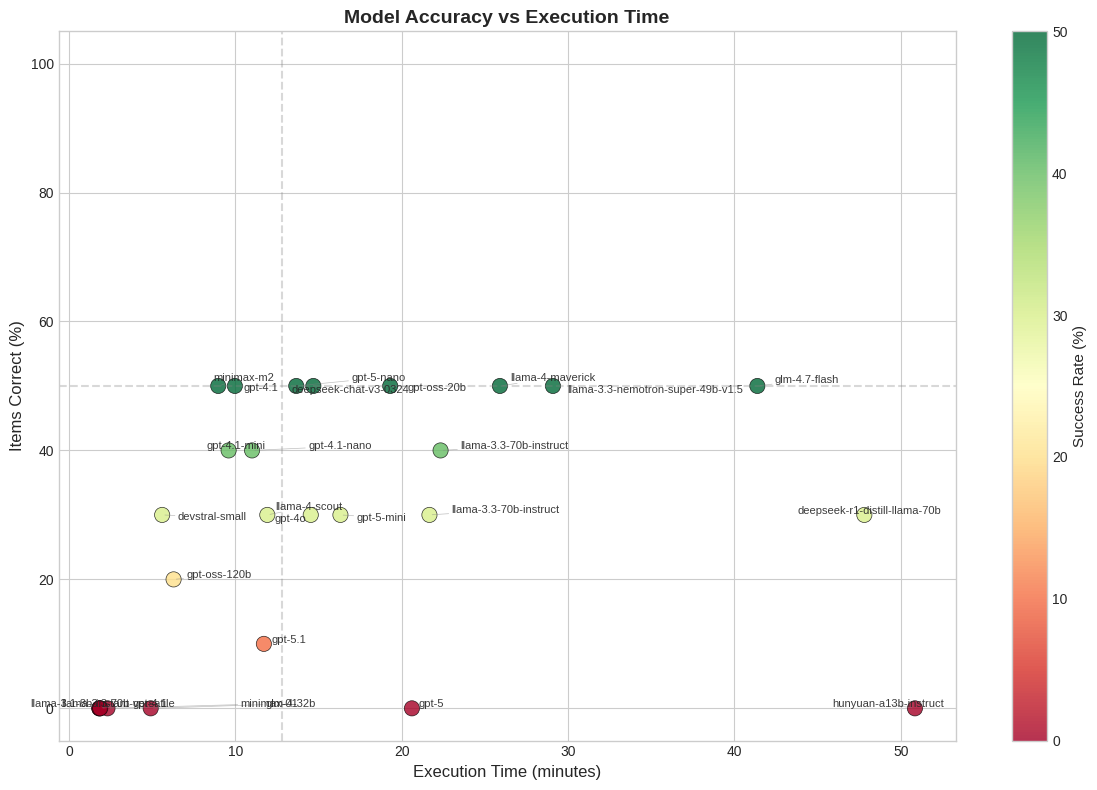


Showing 26 models with timing data
Median execution time: 12.8 minutes


In [8]:
df_with_time = df[df["total_duration_minutes"].notna()].copy()

if len(df_with_time) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Color by success rate
    scatter = ax.scatter(
        df_with_time["total_duration_minutes"],
        df_with_time["success_pct"],
        s=120,
        c=df_with_time["success_pct"],
        cmap="RdYlGn",
        alpha=0.8,
        edgecolors="black",
        linewidths=0.5,
    )

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Success Rate (%)", fontsize=11)

    # Create text labels for adjustText
    texts = []
    for idx, row in df_with_time.iterrows():
        texts.append(
            ax.text(row["total_duration_minutes"], row["success_pct"], row["model_display"], fontsize=8, alpha=0.9)
        )

    # Adjust text positions to avoid overlap
    adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle="-", color="gray", alpha=0.5, lw=0.5),
        expand=(1.2, 1.4),
        force_text=(0.5, 0.8),
        force_static=(0.3, 0.5),
    )

    ax.set_xlabel("Execution Time (minutes)", fontsize=12)
    ax.set_ylabel("Items Correct (%)", fontsize=12)
    ax.set_title("Model Accuracy vs Execution Time", fontsize=14, fontweight="bold")
    ax.set_ylim(-5, 105)

    # Add quadrant lines at median values
    median_time = df_with_time["total_duration_minutes"].median()
    ax.axvline(x=median_time, color="gray", linestyle="--", alpha=0.3)
    ax.axhline(y=50, color="gray", linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nShowing {len(df_with_time)} models with timing data")
    print(f"Median execution time: {median_time:.1f} minutes")

## Plot 3: Cost vs Time

Shows the relationship between API cost and execution time.

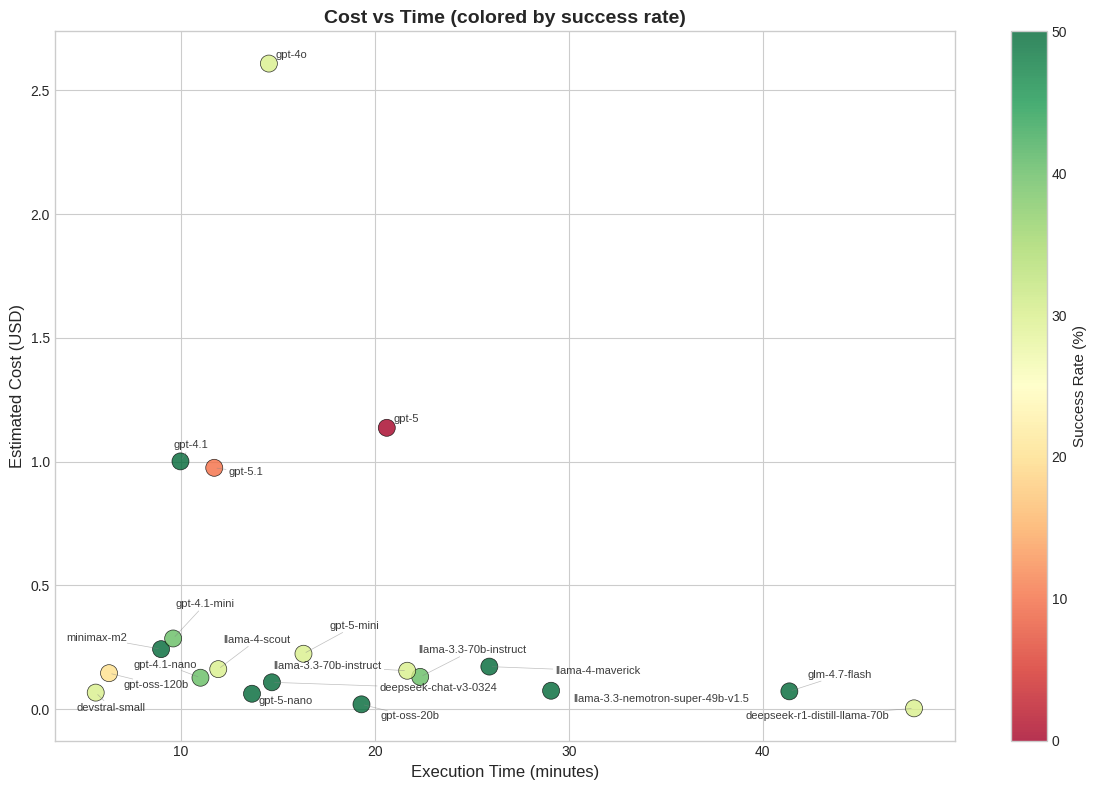


Showing 20 models with both cost and timing data


In [9]:
# Filter to models with both cost and time data
df_cost_time = df[(df["estimated_cost_usd"].notna()) & (df["total_duration_minutes"].notna())].copy()

if len(df_cost_time) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Color by success rate
    scatter = ax.scatter(
        df_cost_time["total_duration_minutes"],
        df_cost_time["estimated_cost_usd"],
        s=150,
        c=df_cost_time["success_pct"],
        cmap="RdYlGn",
        alpha=0.8,
        edgecolors="black",
        linewidths=0.5,
    )

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("Success Rate (%)", fontsize=11)

    # Create text labels for adjustText
    texts = []
    for idx, row in df_cost_time.iterrows():
        texts.append(
            ax.text(
                row["total_duration_minutes"], row["estimated_cost_usd"], row["model_display"], fontsize=8, alpha=0.9
            )
        )

    # Adjust text positions to avoid overlap
    adjust_text(
        texts,
        ax=ax,
        arrowprops=dict(arrowstyle="-", color="gray", alpha=0.5, lw=0.5),
        expand=(1.2, 1.4),
        force_text=(0.5, 0.8),
        force_static=(0.3, 0.5),
    )

    ax.set_xlabel("Execution Time (minutes)", fontsize=12)
    ax.set_ylabel("Estimated Cost (USD)", fontsize=12)
    ax.set_title("Cost vs Time (colored by success rate)", fontsize=14, fontweight="bold")

    plt.tight_layout()
    plt.show()

    print(f"\nShowing {len(df_cost_time)} models with both cost and timing data")
else:
    print("Insufficient data for cost vs time plot.")

## Plot 4: Model Performance Overview

Bar chart showing success rate for all models.

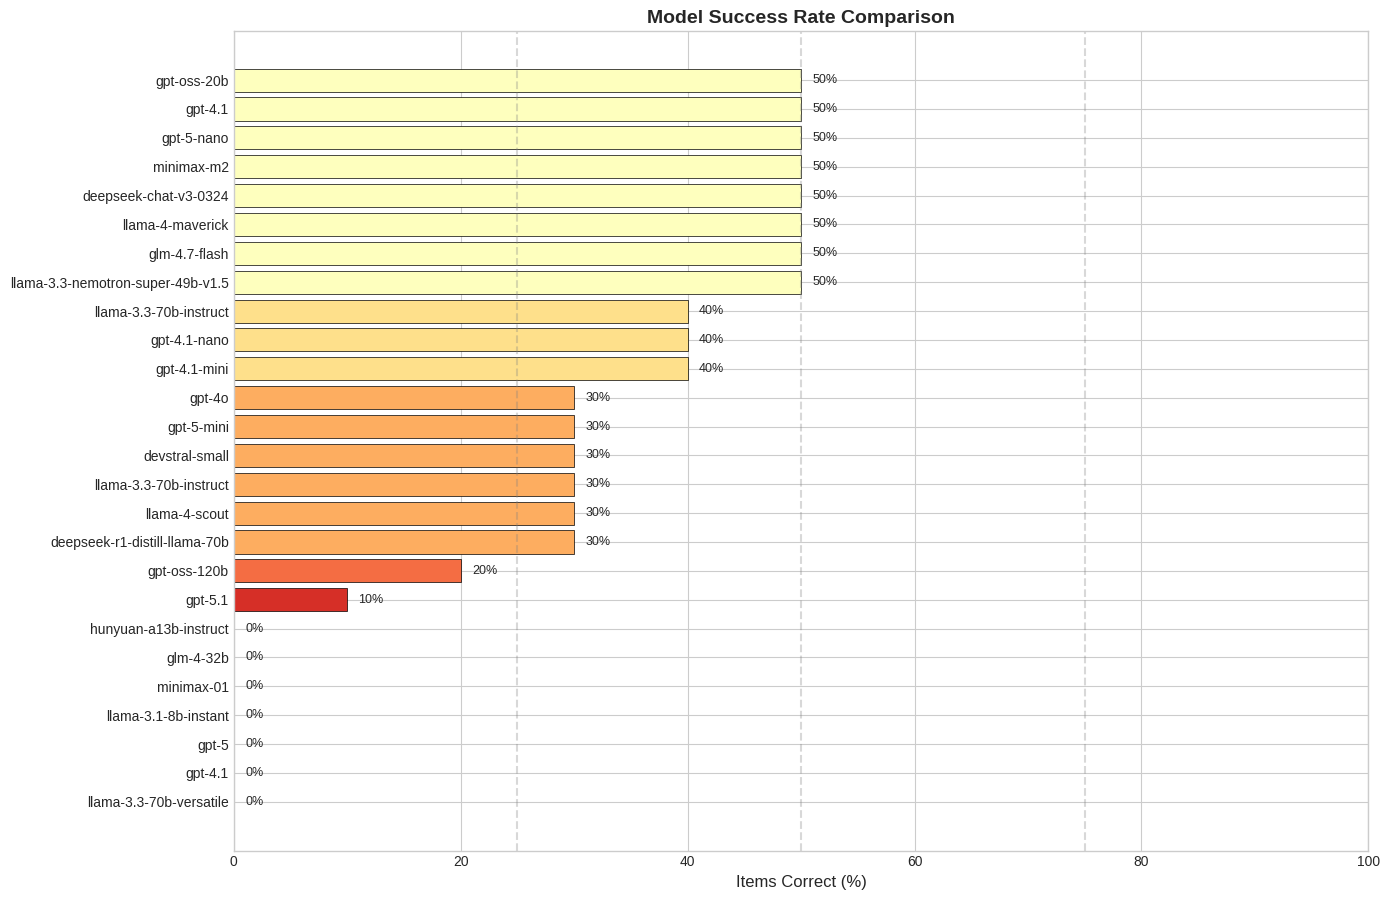

In [10]:
fig, ax = plt.subplots(figsize=(14, max(8, len(df) * 0.35)))

# Sort by success rate
df_sorted = df.sort_values("success_pct", ascending=True)

# Create color map based on success rate
colors = plt.cm.RdYlGn(df_sorted["success_pct"] / 100)

bars = ax.barh(range(len(df_sorted)), df_sorted["success_pct"], color=colors, edgecolor="black", linewidth=0.5)

ax.set_yticks(range(len(df_sorted)))
ax.set_yticklabels(df_sorted["model_display"])
ax.set_xlabel("Items Correct (%)", fontsize=12)
ax.set_title("Model Success Rate Comparison", fontsize=14, fontweight="bold")
ax.set_xlim(0, 100)

# Add value labels
for bar, val in zip(bars, df_sorted["success_pct"]):
    ax.text(val + 1, bar.get_y() + bar.get_height() / 2, f"{val:.0f}%", va="center", fontsize=9)

# Add vertical lines for reference
for pct in [25, 50, 75]:
    ax.axvline(x=pct, color="gray", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

## Plot 5: Time Distribution by Model

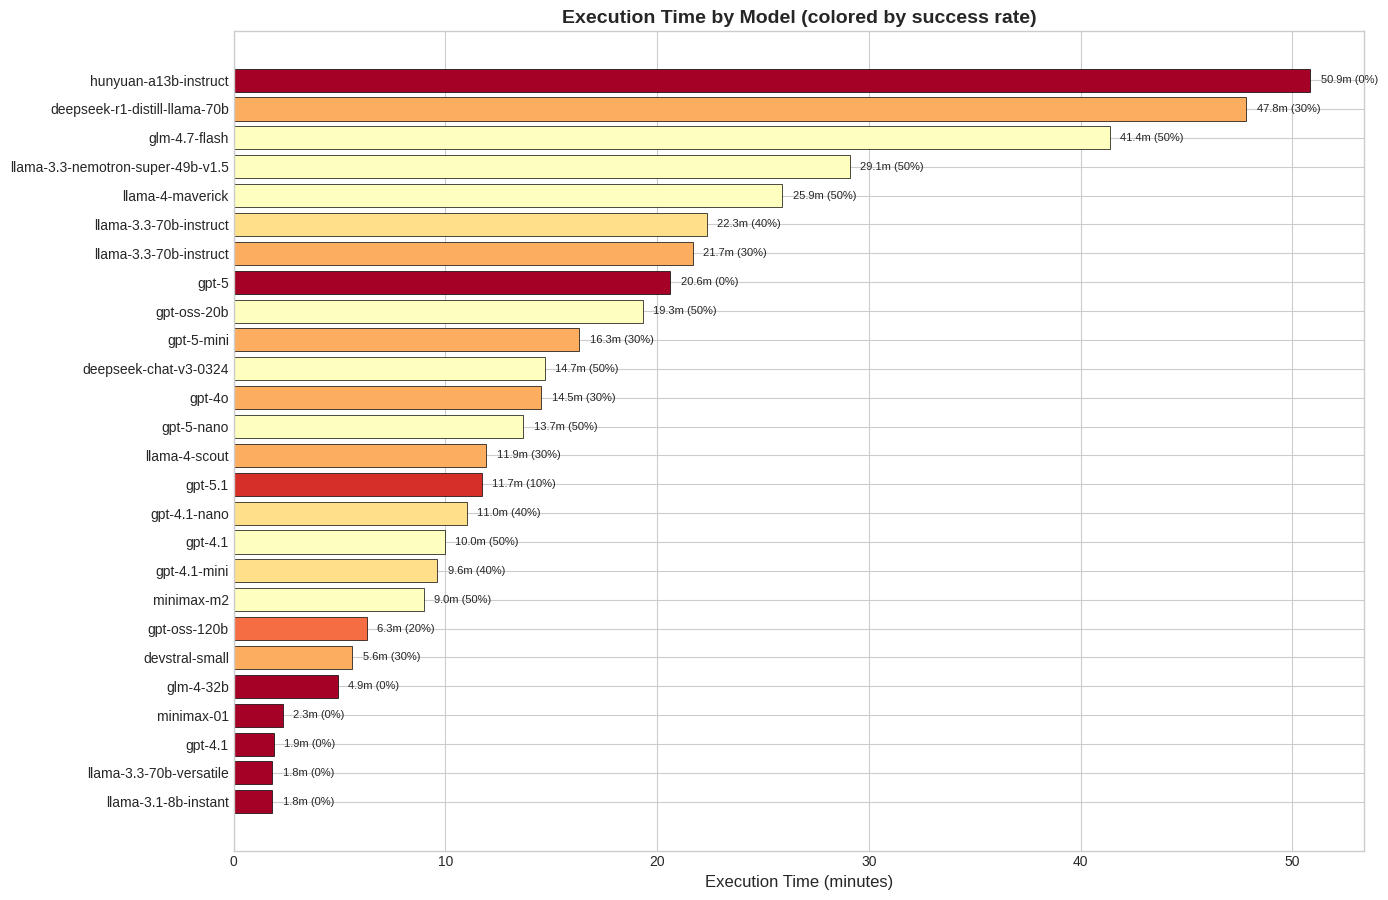

In [11]:
df_with_time = df[df["total_duration_minutes"].notna()].copy()
df_with_time = df_with_time.sort_values("total_duration_minutes", ascending=True)

if len(df_with_time) > 0:
    fig, ax = plt.subplots(figsize=(14, max(8, len(df_with_time) * 0.35)))

    # Color by success rate
    colors = plt.cm.RdYlGn(df_with_time["success_pct"] / 100)

    bars = ax.barh(
        range(len(df_with_time)), df_with_time["total_duration_minutes"], color=colors, edgecolor="black", linewidth=0.5
    )

    ax.set_yticks(range(len(df_with_time)))
    ax.set_yticklabels(df_with_time["model_display"])
    ax.set_xlabel("Execution Time (minutes)", fontsize=12)
    ax.set_title("Execution Time by Model (colored by success rate)", fontsize=14, fontweight="bold")

    # Add value labels with success rate
    for bar, (_, row) in zip(bars, df_with_time.iterrows()):
        ax.text(
            row["total_duration_minutes"] + 0.5,
            bar.get_y() + bar.get_height() / 2,
            f"{row['total_duration_minutes']:.1f}m ({row['success_pct']:.0f}%)",
            va="center",
            fontsize=8,
        )

    plt.tight_layout()
    plt.show()

## Plot 6: Cost Efficiency (Success per Dollar)

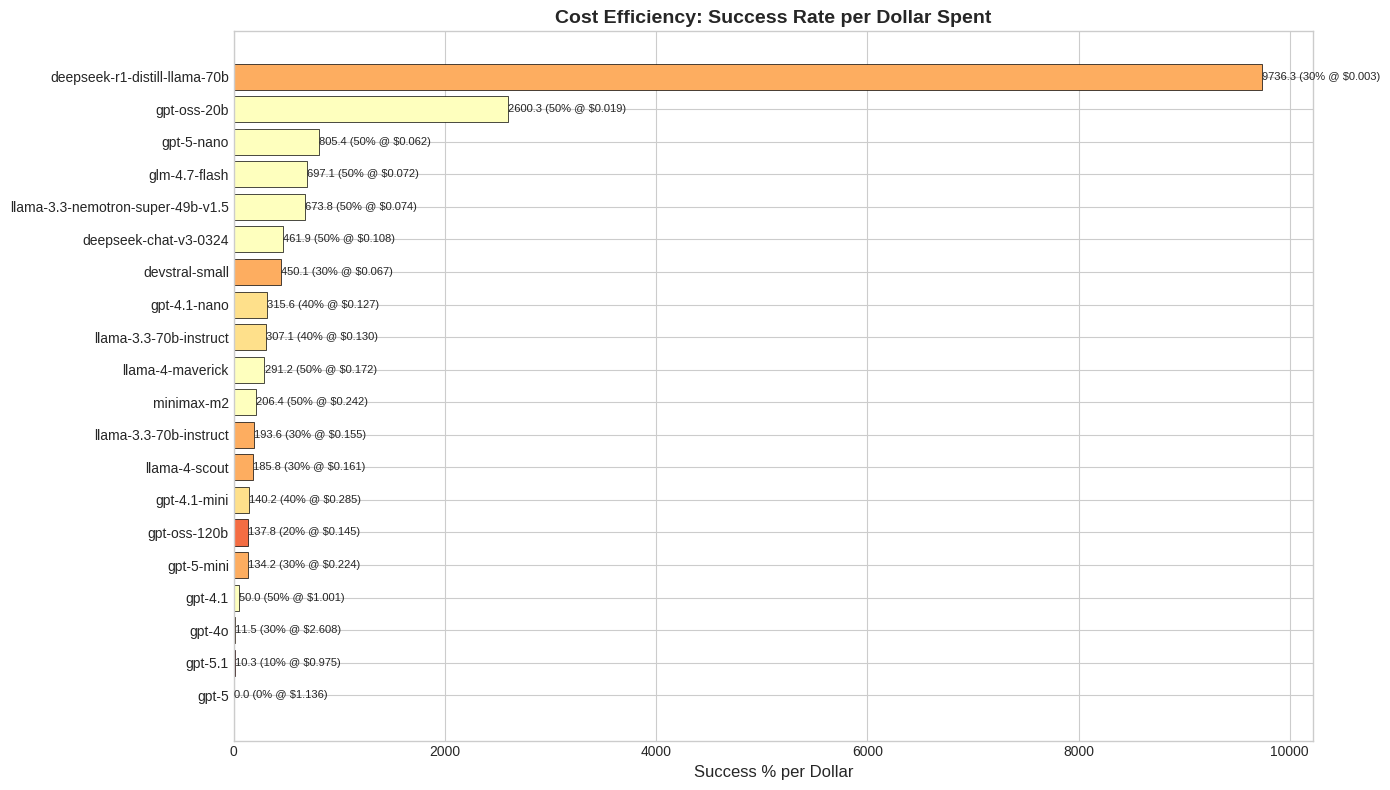

In [12]:
df_with_cost = df[(df["estimated_cost_usd"].notna()) & (df["estimated_cost_usd"] > 0)].copy()

if len(df_with_cost) > 0:
    # Calculate success per dollar
    df_with_cost["success_per_dollar"] = df_with_cost["success_pct"] / df_with_cost["estimated_cost_usd"]
    df_with_cost = df_with_cost.sort_values("success_per_dollar", ascending=True)

    fig, ax = plt.subplots(figsize=(14, max(8, len(df_with_cost) * 0.4)))

    # Color by success rate
    colors = plt.cm.RdYlGn(df_with_cost["success_pct"] / 100)

    bars = ax.barh(
        range(len(df_with_cost)), df_with_cost["success_per_dollar"], color=colors, edgecolor="black", linewidth=0.5
    )

    ax.set_yticks(range(len(df_with_cost)))
    ax.set_yticklabels(df_with_cost["model_display"])
    ax.set_xlabel("Success % per Dollar", fontsize=12)
    ax.set_title("Cost Efficiency: Success Rate per Dollar Spent", fontsize=14, fontweight="bold")

    # Add value labels
    for bar, (_, row) in zip(bars, df_with_cost.iterrows()):
        ax.text(
            row["success_per_dollar"] + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{row['success_per_dollar']:.1f} ({row['success_pct']:.0f}% @ ${row['estimated_cost_usd']:.3f})",
            va="center",
            fontsize=8,
        )

    plt.tight_layout()
    plt.show()
else:
    print("No cost data available for efficiency calculation.")

## Top Performers Summary

In [13]:
print("=" * 60)
print("TOP PERFORMERS SUMMARY")
print("=" * 60)

# Best by success rate
best_accuracy = df.loc[df["success_pct"].idxmax()]
print(f"\n🏆 Highest Accuracy: {best_accuracy['model_display']}")
print(f"   Success Rate: {best_accuracy['success_pct']:.0f}%")
if pd.notna(best_accuracy["total_duration_minutes"]):
    print(f"   Duration: {best_accuracy['total_duration_minutes']:.1f} minutes")
if pd.notna(best_accuracy["estimated_cost_usd"]):
    print(f"   Cost: ${best_accuracy['estimated_cost_usd']:.4f}")

# Fastest with decent success
df_decent = df[df["success_pct"] >= 50].copy()
if len(df_decent) > 0:
    df_decent_time = df_decent[df_decent["total_duration_minutes"].notna()]
    if len(df_decent_time) > 0:
        fastest = df_decent_time.loc[df_decent_time["total_duration_minutes"].idxmin()]
        print(f"\n⚡ Fastest (≥50% success): {fastest['model_display']}")
        print(f"   Success Rate: {fastest['success_pct']:.0f}%")
        print(f"   Duration: {fastest['total_duration_minutes']:.1f} minutes")
        if pd.notna(fastest["estimated_cost_usd"]):
            print(f"   Cost: ${fastest['estimated_cost_usd']:.4f}")

# Cheapest with decent success
df_decent_cost = df_decent[df_decent["estimated_cost_usd"].notna()]
if len(df_decent_cost) > 0:
    cheapest = df_decent_cost.loc[df_decent_cost["estimated_cost_usd"].idxmin()]
    print(f"\n💵 Cheapest (≥50% success): {cheapest['model_display']}")
    print(f"   Success Rate: {cheapest['success_pct']:.0f}%")
    print(f"   Cost: ${cheapest['estimated_cost_usd']:.4f}")
    if pd.notna(cheapest["total_duration_minutes"]):
        print(f"   Duration: {cheapest['total_duration_minutes']:.1f} minutes")

# Best value (success per dollar)
df_with_cost = df[(df["estimated_cost_usd"].notna()) & (df["estimated_cost_usd"] > 0)].copy()
if len(df_with_cost) > 0:
    df_with_cost["efficiency"] = df_with_cost["success_pct"] / df_with_cost["estimated_cost_usd"]
    best_value = df_with_cost.loc[df_with_cost["efficiency"].idxmax()]
    print(f"\n💰 Best Value (success/dollar): {best_value['model_display']}")
    print(f"   Success Rate: {best_value['success_pct']:.0f}%")
    print(f"   Cost: ${best_value['estimated_cost_usd']:.4f}")
    print(f"   Efficiency: {best_value['efficiency']:.1f}%/dollar")

# Best time efficiency (success per minute)
df_with_time = df[df["total_duration_minutes"].notna()].copy()
if len(df_with_time) > 0:
    df_with_time["time_efficiency"] = df_with_time["success_pct"] / df_with_time["total_duration_minutes"]
    best_time_eff = df_with_time.loc[df_with_time["time_efficiency"].idxmax()]
    print(f"\n⏱️  Best Time Efficiency (success/min): {best_time_eff['model_display']}")
    print(f"   Success Rate: {best_time_eff['success_pct']:.0f}%")
    print(f"   Duration: {best_time_eff['total_duration_minutes']:.1f} minutes")
    print(f"   Efficiency: {best_time_eff['time_efficiency']:.2f}%/min")

print("\n" + "=" * 60)

TOP PERFORMERS SUMMARY

🏆 Highest Accuracy: gpt-4.1
   Success Rate: 50%
   Duration: 10.0 minutes
   Cost: $1.0007

⚡ Fastest (≥50% success): minimax-m2
   Success Rate: 50%
   Duration: 9.0 minutes
   Cost: $0.2422

💵 Cheapest (≥50% success): gpt-oss-20b
   Success Rate: 50%
   Cost: $0.0192
   Duration: 19.3 minutes

💰 Best Value (success/dollar): deepseek-r1-distill-llama-70b
   Success Rate: 30%
   Cost: $0.0031
   Efficiency: 9736.3%/dollar

⏱️  Best Time Efficiency (success/min): minimax-m2
   Success Rate: 50%
   Duration: 9.0 minutes
   Efficiency: 5.57%/min



## Raw Data Export

In [14]:
# Display raw data for reference
display_cols = [
    "model_display",
    "provider",
    "success_pct",
    "total_duration_minutes",
    "estimated_cost_usd",
    "cost_source",
    "input_tokens",
    "output_tokens",
]
df[display_cols]

,model_display,provider,success_pct,total_duration_minutes,estimated_cost_usd,cost_source,input_tokens,output_tokens
0,gpt-4.1,openai,50.0,9.973660,1.000670,recorded,535451,12085
1,gpt-oss-20b,openrouter,50.0,19.310419,0.019229,openrouter_api,579896,76308
2,llama-3.3-nemotron-super-49b-v1.5,openrouter,50.0,29.091443,0.074210,openrouter_api,393389,87178
3,glm-4.7-flash,openrouter,50.0,41.381865,0.071722,openrouter_api,455244,99638
4,llama-4-maverick,openrouter,50.0,25.906275,0.171718,openrouter_api,1064382,20102
5,deepseek-chat-v3-0324,openrouter,50.0,14.690405,0.108246,openrouter_api,504859,14164
6,minimax-m2,openrouter,50.0,8.973831,0.242195,openrouter_api,655907,74939
7,gpt-5-nano,openai,50.0,13.663763,0.062081,recorded,832777,79970
8,gpt-4.1-nano,openai,40.0,11.004943,0.126742,recorded,1370240,30552
9,gpt-4.1-mini,openai,40.0,9.596960,0.285348,recorded,754393,16496
